In [1]:
from helpers.shared_imports import *
%matplotlib inline

In [2]:
from helpers.integrate import Controller, d_state_bebop, mass_bebop, get_unbiased_controller, simulate_system_odeint
from helpers.vis import trajectory_plot_compare
from helpers.optimality_eval import get_equilibrium
from helpers.c_generator import generate_c_code

In [3]:
import subprocess, ctypes
from ctypes import c_float, POINTER

In [4]:
pkl_name = 'power_bebop_h04_n0100.pkl'

model_path = 'models_pickled/bebop_power/'
nn_controller_orig = Controller(path_to_pickle=os.path.join(model_path, pkl_name))

equ_point = get_equilibrium(nn_controller_orig)
nn_controller = get_unbiased_controller(nn_controller_orig, equ_point)

The following C files are fixed (i.e. same for all NNs):
* `nn.c` - code for neural network operations
* `nn.h` - exposed functions
* `pd_gains.h` - PD gains

The following functions are exposed in *nn.h*:
* `nn(float *state, float *control)` - only neural network
* `nn_stable(float *state, float *control)` - NN with PD
* `nested_control(float *state, float *control)` - only PD

There is also a makefile and file *main.c* for testing purposes.

In the folder *c_files/templates/* are files from which part of the C code is generated.

The generated files are:
* `nn_params.h` 
* `nn_params.c`

They specify important parameters such as the weights and biases as well as properties of the NN e.g. number of layers as constant variables that are used in *nn.c*.

In [5]:
template_dir = 'c_files/templates/'
export_dir = 'c_code'

generate_c_code(nn_controller_orig, template_dir, export_dir, equ_point)

You need to manually copy the fixed C files to the `export_dir`.

We then compile the code to a shared library (.so file) using `make lib`.

This is necessary for interfacing with the C functions from Python.

In [9]:
subprocess.call('make lib -C {:s}'.format(export_dir), shell=True)

0

Written a class to wrap the code that interfaces with the C code.

It has a function *compute_control()* so it can be used like class *Controller* in the simulation functions.

The constructor has the flag `with_pid` which determines whether *nn()* or *nn_stable()* is used.

In [6]:
class C_Controller:
    def __init__(self, lib_path, with_pid=False):
        clib = ctypes.CDLL(lib_path)
        self.nn = clib.nn_stable if with_pid else clib.nn
        self.nn.argtypes = [POINTER(c_float), POINTER(c_float)]
        
    def compute_control(self, state):
        state_arr = (c_float * 5)(*state)
        control_arr = (c_float * 2)()
        self.nn(state_arr, control_arr)
        return np.array(control_arr[:])
    
c_controller = C_Controller(export_dir + '/nn.so')

** C and Python controller comparison**

The controls are equivalent to 5.d.p

In [8]:
state = np.array([0.1,-0.1,0.1,-0.1,0.2])

out = c_controller.compute_control(state)
print('{:4}:'.format('C'), ['{:.10f}'.format(x) for x in out])

out = nn_controller.compute_control(state)
print('Orig:', ['{:.10f}'.format(x) for x in out])

C   : ['0.0240540504', '-5.8137774467']
Orig: ['0.0240537652', '-5.8137804978']


C controller is faster than the Python!

In [16]:
%timeit nn_controller.compute_control(state)
%timeit c_controller.compute_control(state)

403 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
116 µs ± 281 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
initial_state = [10., 0.1, 10., 0.1, 0.2]

We observe that the trajectories overlap.

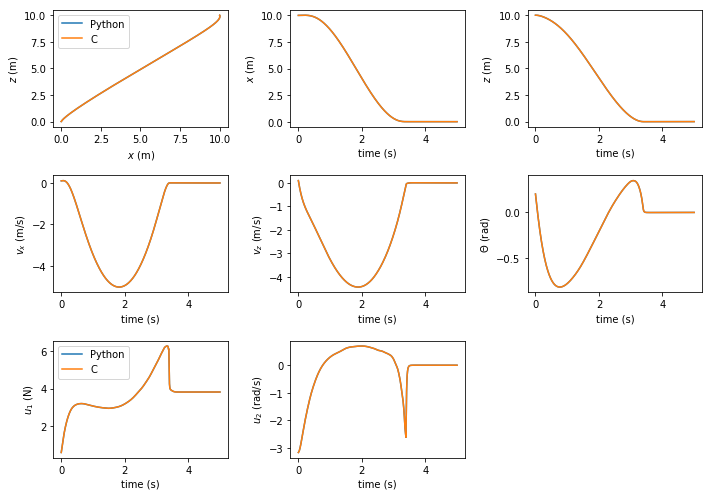

In [19]:
traj_sim = simulate_system_odeint(nn_controller, \
                                  d_state_bebop, \
                                  initial_state, \
                                  mass=mass_bebop, \
                                  dt=0.01, \
                                  max_time=5.0)

traj_sim_c = simulate_system_odeint(c_controller, \
                                  d_state_bebop, \
                                  initial_state, \
                                  mass=mass_bebop, \
                                  dt=0.01, \
                                  max_time=5.0)

trajectory_plot_compare(traj_sim_c, traj_sim, label1='C', label2='Python')
plt.show()